# Exploratory Data Analysis

### Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

### Read in 15-minute and Hourly Data

In [3]:
df_hourly = pd.read_csv('../data/interim/hourly_data.csv', parse_dates=[0], index_col=0)

In [4]:
df_hourly.columns

Index(['Shark Meter, KWH', 'AE 500kW 1, KWH', 'AE 500kW 2, KWH', 'Month',
       'Hour', 'Year'],
      dtype='object')

In [5]:
df_fifteen = pd.read_csv('../data/interim/fifteen_minute_data.csv', parse_dates=[0], index_col=0)

In [6]:
df_fifteen.columns

Index(['Shark Meter, KWtotal Kilowatts', 'AE 500kW 1, AC Power Kilowatts',
       'AE 500kW 2, AC Power Kilowatts',
       '(Offline) Weather Station - POA (POA)* Watts/meter²',
       'RECx31 Weather Station, Module Temp Degrees Celsius',
       'RECx31 Weather Station, Ambient Temp Degrees Celsius',
       'AE 500kW 1, PV current Amps', 'AE 500kW 2, PV current Amps',
       'AE 500kW 1, PV voltage Volts', 'AE 500kW 2, PV voltage Volts'],
      dtype='object')

### Daily and Annual Seasonality

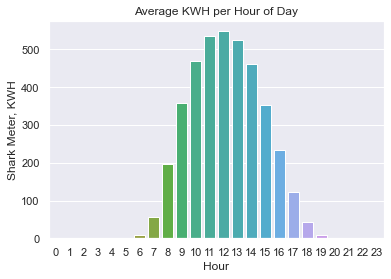

In [7]:
KWH_by_hour = df_hourly[['Shark Meter, KWH','Hour']].groupby(by='Hour').mean().reset_index()
sns.barplot(data=KWH_by_hour, x='Hour',y='Shark Meter, KWH')
plt.title('Average KWH per Hour of Day');

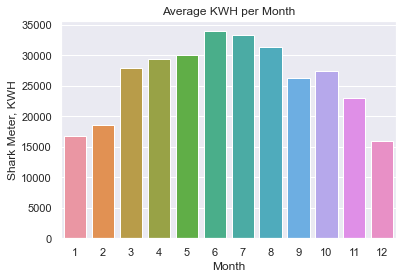

In [8]:
# First group by month and year summing the energy, then take the mean
KWH_by_monthyear = df_hourly[['Shark Meter, KWH','Month','Year']].groupby(by=['Month','Year']).sum().reset_index()
KWH_by_month = KWH_by_monthyear[['Shark Meter, KWH','Month']].groupby(by='Month').mean().reset_index()
sns.barplot(data=KWH_by_month, x='Month',y='Shark Meter, KWH')
plt.title('Average KWH per Month');

We can see the strong hourly and yearly patterns in terms of energy output.  

### Seasonal Decomposition

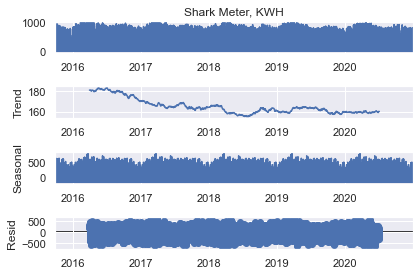

In [10]:
decomp = seasonal_decompose(df_hourly['Shark Meter, KWH'], period=24*365, model = 'add')
decomp.plot();

It's really hard to see the seasonality here because the data is so noisy, so let's try this again with a rolling average.  

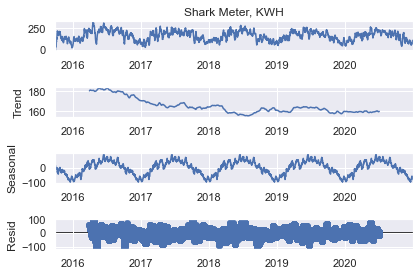

In [11]:
df_hourly_rolling_7D = df_hourly['Shark Meter, KWH'].rolling(window='7D').mean()
decomp = seasonal_decompose(df_hourly_rolling_7D, period=24*365, model = 'add')
decomp.plot();

Now we clearly see the seasonality, the downward trend as the solar cells degrade.  We also see that the residuals are still quite large.  

### ACF and PACF

Let's make the data staionary and then plot the ACF and PACF.

In [12]:
diff_hourly_rolling_7D = df_hourly_rolling_7D.diff(periods=1)
diff_hourly_rolling_7D.dropna(inplace=True)

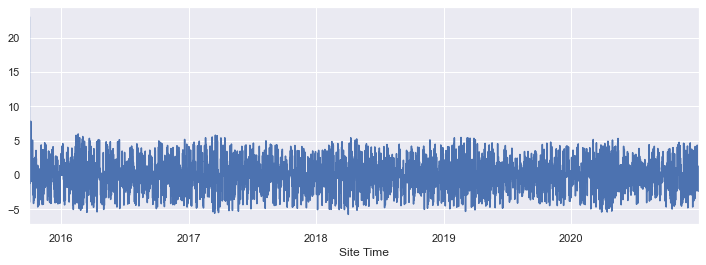

In [13]:
diff_hourly_rolling_7D.plot(figsize=(12,4));

That looks pretty stationary! 

In [14]:
adfuller(diff_hourly_rolling_7D)

(-32.65787236907025,
 0.0,
 26,
 46028,
 {'1%': -3.4304920801409695,
  '5%': -2.861602796384948,
  '10%': -2.5668034244596347},
 82528.63384004944)

The ADFuller test shows a p-value of 0, so we can reject the null hypothesis and conclude that our differenced time series is now stationary. Let's plot the ACF and PACF again.

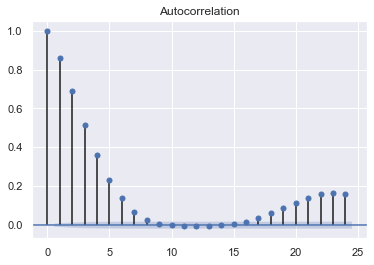

In [15]:
plot_acf(diff_hourly_rolling_7D, lags=24);

We can see the autocorrelation corresponding to the hours of the day.  

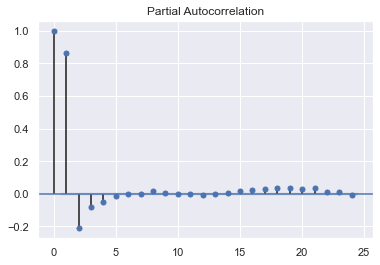

In [16]:
plot_pacf(diff_hourly_rolling_7D, lags=24);

These ACF and PACF plots would imply an AR2 model would be appropriate to model the series. 

### Power, Current, and Irradiance

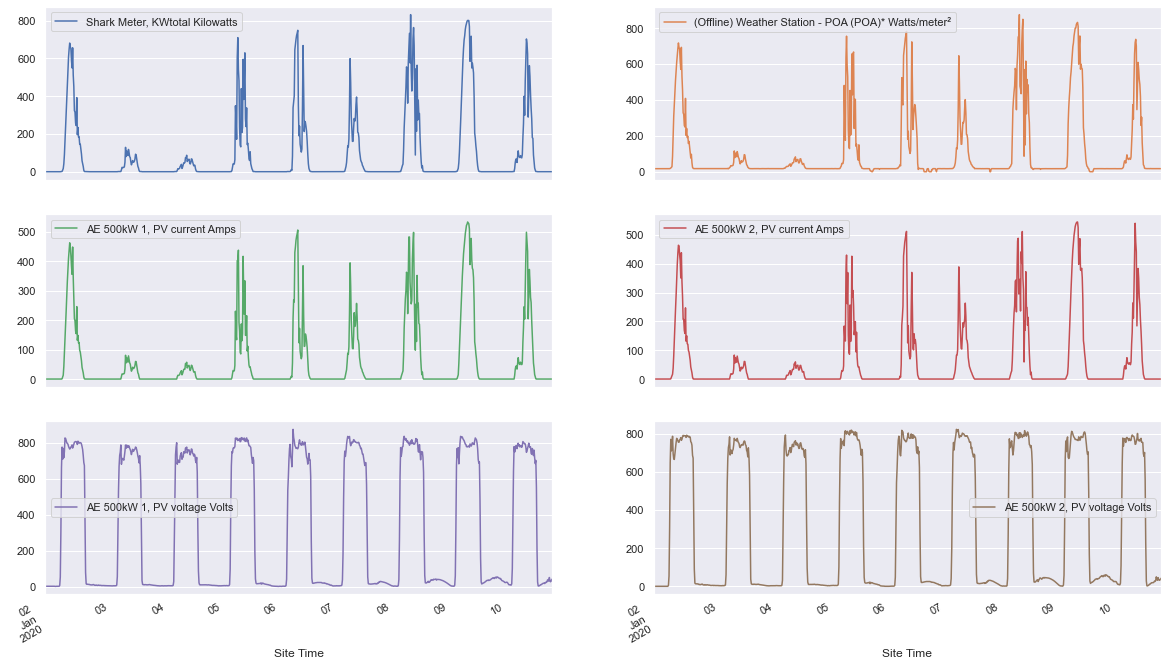

In [17]:
df_fifteen[['Shark Meter, KWtotal Kilowatts','(Offline) Weather Station - POA (POA)* Watts/meter²','AE 500kW 1, PV current Amps','AE 500kW 2, PV current Amps','AE 500kW 1, PV voltage Volts','AE 500kW 2, PV voltage Volts']]\
        .loc['2020-01-02':'2020-01-10'].plot(subplots=True, layout=(3,2), figsize=(20,12));

So we can see that power tracks current which tracks irradiance. 

### Explore Outages / Underperformance of Inverters
Let's look at another instance, in late 2018, when it appears that one of the inverters was not functioning. 

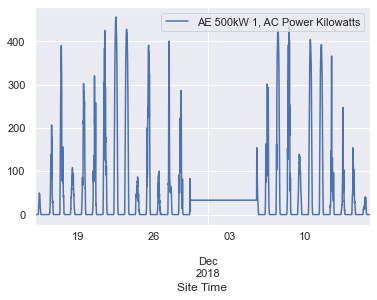

In [19]:
df_fifteen[['AE 500kW 1, AC Power Kilowatts']].loc['2018-11-15':'2018-12-15'].plot();

So this is in instance when the inverter is not functioning correctly and is not producing power. We know this because the shark meter is producing half the normal power during this time. 
As a matter of fact, let's plot the difference between the shark meter and the sum of the two interverters.  

In [22]:
df_fifteen['Power difference'] = df_fifteen.apply(lambda x: x['Shark Meter, KWtotal Kilowatts'] \
                                   - x['AE 500kW 1, AC Power Kilowatts'] - x['AE 500kW 2, AC Power Kilowatts'], axis=1)

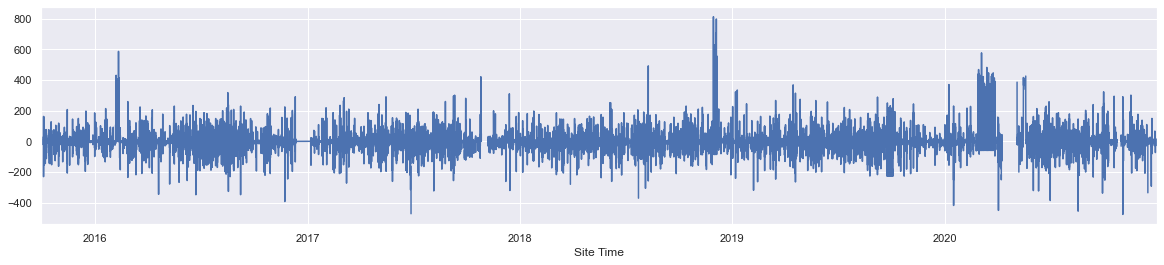

In [24]:
df_fifteen['Power difference'].plot(figsize=(20,4));

Let's look at one particular area.

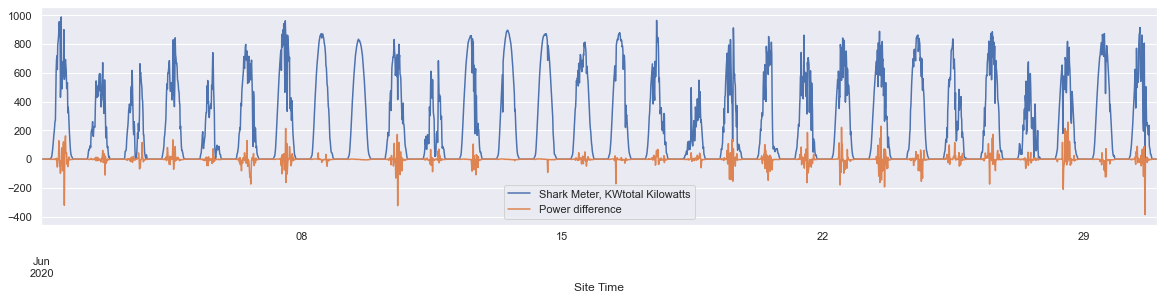

In [26]:
df_fifteen[['Shark Meter, KWtotal Kilowatts','Power difference']].loc['2020-06'].plot(figsize=(20,4));

Ok, so the shark meter does not exactly equal the sum of the two inverters. Sometimes it's higher and sometimes it's lower.  But when the difference is large it means that there is a communication error between the inverters and the meter.  

Another thing we can look at is the difference between the two inverters.  They should be generating similar outputs. Let's look at the difference.  

In [28]:
df_fifteen['Diff Power Inv1 and Inv2'] = df_fifteen.apply(lambda x: x['AE 500kW 1, AC Power Kilowatts'] - x['AE 500kW 2, AC Power Kilowatts'], axis=1)

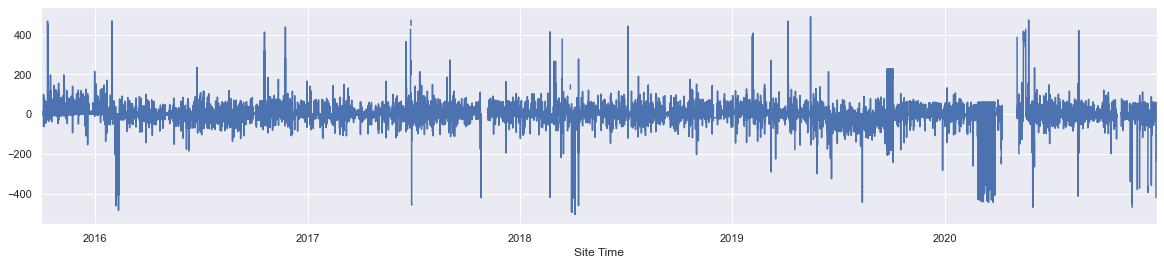

In [30]:
df_fifteen['Diff Power Inv1 and Inv2'].plot(figsize=(20,4));

So that's interesting...all of those spikes are times when the inverters are not producing the same amount of power. What we might want to look at is times when the shark meter matches the sum of the two inverters but the inverters don't match each other. That would be a sign that one of the inverters was not producing correctly.

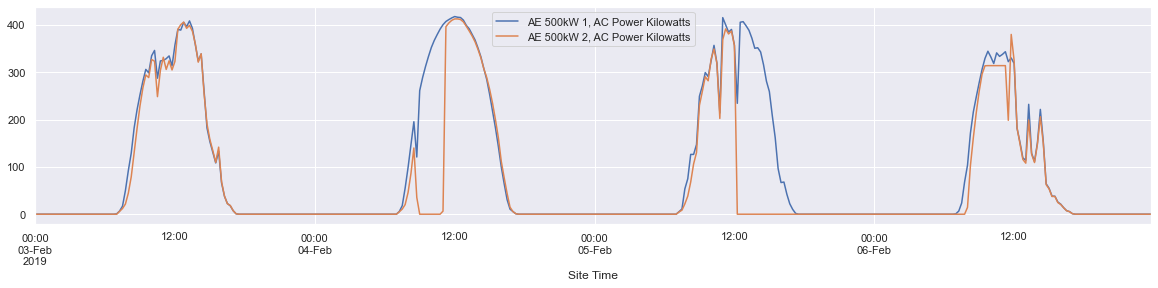

In [33]:
df_fifteen[['AE 500kW 1, AC Power Kilowatts','AE 500kW 2, AC Power Kilowatts']].loc['2019-02-03':'2019-02-06'].plot(figsize=(20,4));

So presumably this is a problem with the second inverter.  We can see that over several days it has some strange behaviour.  


### Exogeneous Variables

Let's explore the relationship between energy output and the exogeneous variables. We've already seen that energy output tracks irradiance quite closely.  Let's see if we see any impact from temperature.   

In [36]:
df_fifteen.columns

Index(['Shark Meter, KWtotal Kilowatts', 'AE 500kW 1, AC Power Kilowatts',
       'AE 500kW 2, AC Power Kilowatts',
       '(Offline) Weather Station - POA (POA)* Watts/meter²',
       'RECx31 Weather Station, Module Temp Degrees Celsius',
       'RECx31 Weather Station, Ambient Temp Degrees Celsius',
       'AE 500kW 1, PV current Amps', 'AE 500kW 2, PV current Amps',
       'AE 500kW 1, PV voltage Volts', 'AE 500kW 2, PV voltage Volts',
       'Power difference', 'Diff Power Inv1 and Inv2'],
      dtype='object')

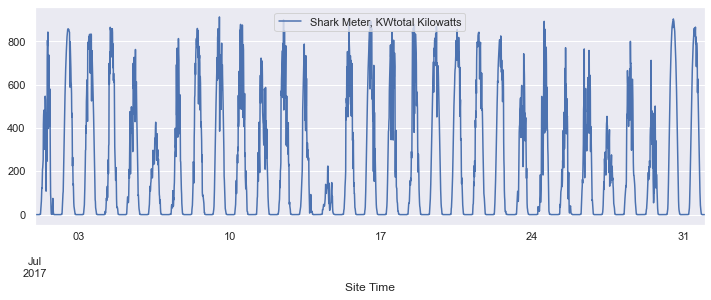

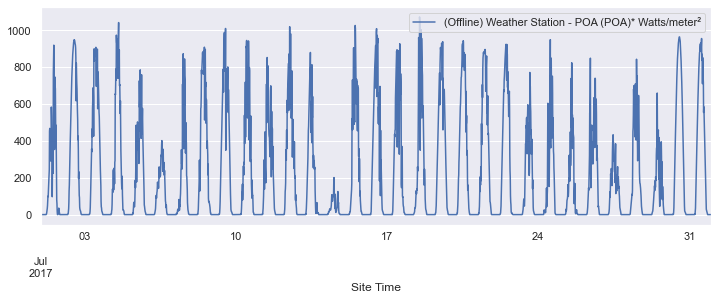

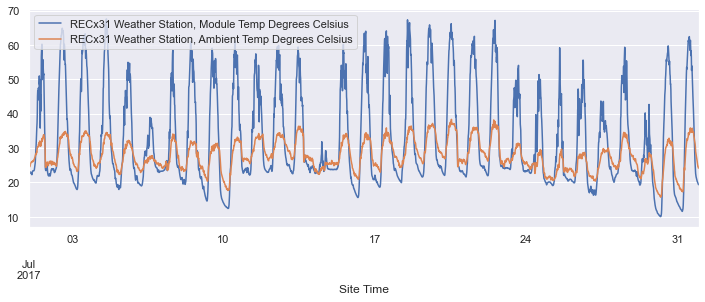

In [39]:
df_fifteen[['Shark Meter, KWtotal Kilowatts']].loc['2017-07'].plot(figsize=(12,4));
df_fifteen[['(Offline) Weather Station - POA (POA)* Watts/meter²']].loc['2017-07'].plot(figsize=(12,4));
df_fifteen[['RECx31 Weather Station, Module Temp Degrees Celsius','RECx31 Weather Station, Ambient Temp Degrees Celsius']].loc['2017-07'].plot(legend=True,figsize=(12,4));

We can see that energy output tracks both irradiance and temperature closely.  